In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


In [ ]:
df = pd.read_csv("healthcare_dataset.csv")

print("Dataset loaded with shape:", df.shape)
print("Columns:", df.columns.tolist())


Dataset loaded with shape: (55500, 15)
Columns: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']


In [ ]:
df = df.dropna()


In [ ]:
def generate_strong_readmission(row):
    score = 0
    if row['Medical Condition'] in ['Heart Disease', 'Diabetes', 'Hypertension']:
        score += 100
    if row['Age'] > 60:
        score += 50
    if row['Admission Type'] == 'Emergency':
        score += 50
    if row['Billing Amount'] > 20000:
        score += 40
    if row['Test Results'] == 'Critical':
        score += 80
    elif row['Test Results'] == 'Abnormal':
        score += 40
    prob = min(score / 200, 1.0)
    return np.random.binomial(1, prob)

df['readmitted'] = df.apply(generate_strong_readmission, axis=1)


In [ ]:
print(df.head())
print(df.columns)


            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medication  \
0    18856.281306    

In [ ]:
cols_to_drop = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Room Number', 'Discharge Date']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')


In [ ]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_encoded = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [62]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True)
}

results = {}
roc_data = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # ROC data
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(roc_auc)



RandomForest Accuracy: 0.7177
[[3897 1424]
 [1710 4069]]
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      5321
           1       0.74      0.70      0.72      5779

    accuracy                           0.72     11100
   macro avg       0.72      0.72      0.72     11100
weighted avg       0.72      0.72      0.72     11100

0.8068602079755358

LogisticRegression Accuracy: 0.7381
[[4032 1289]
 [1618 4161]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      5321
           1       0.76      0.72      0.74      5779

    accuracy                           0.74     11100
   macro avg       0.74      0.74      0.74     11100
weighted avg       0.74      0.74      0.74     11100

0.8242034755120309

SVM Accuracy: 0.7359
[[4159 1162]
 [1769 4010]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      5321
           1       0.78     

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7121621621621622

Confusion Matrix:
 [[5982 1280]
 [1915 1923]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      7262
           1       0.60      0.50      0.55      3838

    accuracy                           0.71     11100
   macro avg       0.68      0.66      0.67     11100
weighted avg       0.70      0.71      0.71     11100



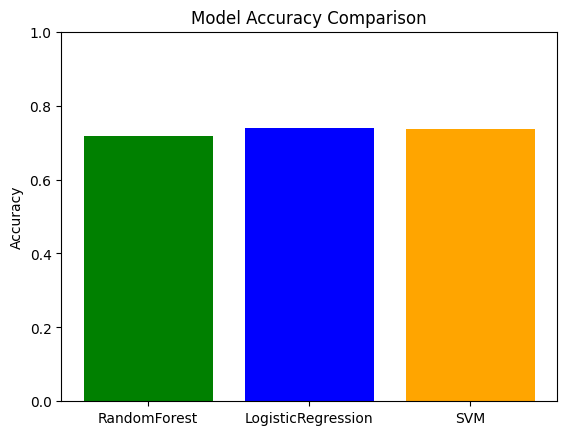

In [63]:
plt.bar(results.keys(), results.values(), color=['green','blue','orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("A
ccuracy")
plt.ylim(0,1)
plt.show()


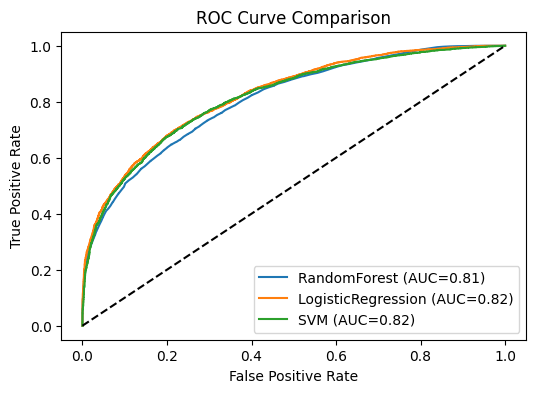

In [64]:
plt.figure(figsize=(6,4))
for name, (fpr, tpr, auc_score) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


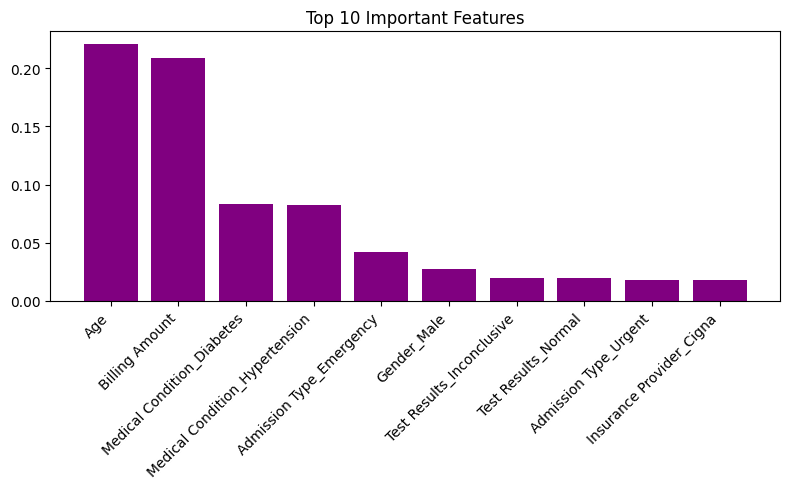

In [65]:
rf_model = models["RandomForest"]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(10), importances[indices[:10]], color="purple", align="center")
plt.xticks(range(10), [X_encoded.columns[i] for i in indices[:10]], rotation=45, ha='right')
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()


In [66]:
def predict_patient_risk_with_graph(patient_data):
    patient_encoded = pd.get_dummies(pd.DataFrame([patient_data]))
    patient_encoded = patient_encoded.reindex(columns=X_encoded.columns, fill_value=0)
    patient_scaled = scaler.transform(patient_encoded)

    prob = models["RandomForest"].predict_proba(patient_scaled)[0][1]
    risk = "High" if prob>0.7 else "Medium" if prob>0.4 else "Low"

    print(f"Predicted Readmission Risk: {risk} ({prob*100:.2f}%)")
    plt.bar(['No Risk', 'Readmission Risk'], [1-prob, prob], color=['green','red'])
    plt.title("Patient Risk Probability")
    plt.ylim(0,1)
    plt.show()


Predicted Readmission Risk: Medium (69.00%)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


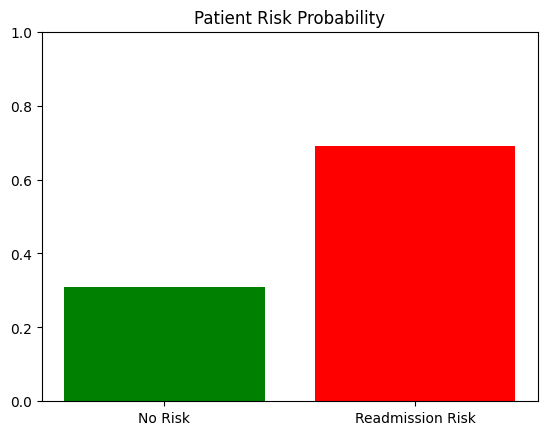

In [67]:
patient_high = {
    "Age": 75, "Gender": "Male", "Blood Type": "O+", "Medical Condition": "Heart Disease",
    "Insurance Provider": "XYZ", "Billing Amount": 60000, "Admission Type": "Emergency",
    "Medication": "Drug A", "Test Results": "Critical"
}

predict_patient_risk_with_graph(patient_high)



In [68]:
import joblib

# Save model, scaler, and encoded columns
joblib.dump(models["RandomForest"], "readmission_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(list(X_encoded.columns), "columns.pkl")



['columns.pkl']

In [70]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [74]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load model, scaler, and columns
model = joblib.load("readmission_model.pkl")
scaler = joblib.load("scaler.pkl")
columns = joblib.load("columns.pkl")

st.title("Hospital Readmission Risk Predictor")
st.write("Predict risk of readmission for patients with chronic conditions.")

# --- Collect User Inputs ---
age = st.number_input("Age", 0, 120, 50)
gender = st.selectbox("Gender", ["Male", "Female"])
blood_type = st.selectbox("Blood Type", ["A+", "A-", "B+", "B-", "AB+", "AB-", "O+", "O-"])
medical_condition = st.selectbox("Medical Condition", ["Heart Disease", "Diabetes", "Hypertension", "Asthma", "Cancer"])
insurance = st.text_input("Insurance Provider", "XYZ Insurance")
billing = st.number_input("Billing Amount", 0, 100000, 20000)
admission_type = st.selectbox("Admission Type", ["Emergency", "Elective", "Urgent"])
medication = st.text_input("Medication", "Drug A")
test_results = st.selectbox("Test Results", ["Normal", "Abnormal", "Critical"])

# Create dataframe
input_data = pd.DataFrame([{
    "Age": age,
    "Gender": gender,
    "Blood Type": blood_type,
    "Medical Condition": medical_condition,
    "Insurance Provider": insurance,
    "Billing Amount": billing,
    "Admission Type": admission_type,
    "Medication": medication,
    "Test Results": test_results
}])

# Encode & scale
input_encoded = pd.get_dummies(input_data)
input_encoded = input_encoded.reindex(columns=columns, fill_value=0)
input_scaled = scaler.transform(input_encoded)

# Predict
prob = model.predict_proba(input_scaled)[0][1]
risk = "High" if prob > 0.7 else "Medium" if prob > 0.4 else "Low"

st.subheader(f"Predicted Readmission Risk: {risk} ({prob*100:.2f}%)")

# Graph
st.bar_chart({"Risk": [prob], "Safe": [1-prob]})


Writing app.py


In [78]:
import joblib

# Save the trained model, scaler, and columns
joblib.dump(models["RandomForest"], "readmission_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(list(X_encoded.columns), "columns.pkl")

print("Model, scaler, and columns saved!")


Model, scaler, and columns saved!


In [77]:
y


,readmitted
0,0
1,0
2,1
3,1
4,0
...,...
55495,0
55496,1
55497,1
55498,0


In [85]:
!pip install pyngrok
!ngrok authtoken 30KjVhGzne1bUFlqp8aiAKbgQcb_28SdNFVvgxMj6SD4wr1Bv
!streamlit run app.py --server.port 8501 & ngrok http 8501


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.94.174:8501

  Stopping...
Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyngrok/ngrok.py", line 687, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.11/dist-packages/pyngrok/ngrok.py", line 675, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.11/dist-packages/pyngrok/process.py", line 312, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.11/subprocess.py", line 391, in call
    return p.wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1264, in wait
    return self._wait(timeout=timeout)
           ^

In [86]:
!pip install pyngrok


In [87]:
from pyngrok import ngrok

# Add your token here
!ngrok authtoken 30KjVhGzne1bUFlqp8aiAKbgQcb_28SdNFVvgxMj6SD4wr1Bv


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [88]:
# Start Streamlit app
get_ipython().system_raw('streamlit run app.py --server.port 8501 &')

# Create public tunnel
public_url = ngrok.connect(8501)
print("Your Streamlit App URL:", public_url)


Your Streamlit App URL: NgrokTunnel: "https://5428ace2305b.ngrok-free.app" -> "http://localhost:8501"
